# Exploratory data analysis

## Preamble

In this notebook we will efectively begin our exploratory data analysis.

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import sys

import janitor
from sklearn import preprocessing
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Boilerplate code needed to be able to import from another directory.
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from scripts.eda_tools import count_and_normalize, check_correlation, norm_barplot

file_path = Path('../data/processed/proc_data.csv', index=False)

data = pd.read_csv(file_path)

data

,id,admitted,window_of_admission,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,...,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel
0,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000
4,2,1,4.0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1406,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1407,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1408,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


## Demographics

### Preparing the *DataFrame*

Let's begin our analysis with the demographics. First we have to make sure we have only one row per patient, so as to not skew our conclusions. Then, we will create another *DataFrame* with just the demographics features.

In [2]:
demographics_per_id = (
    data
    .groupby('id')
    [['admitted', 'age_above65', 'age_percentil', 'gender']]
    .first()
)

demographics_per_id

,admitted,age_above65,age_percentil,gender
id,,,,
0,1,1,5,0
2,1,0,0,0
3,0,0,3,1
4,0,0,0,0
5,0,0,0,0
...,...,...,...,...
380,1,0,3,1
381,0,1,9,0
382,1,0,4,0


A few simple barplots will allow us to see if these feature are balanced.

### *admitted*

Before anything else, we should take a look at the proportion of patients that were admitted to the ICU.

,counts,normalized_counts
admitted,,
0,190,0.538244
1,163,0.461756


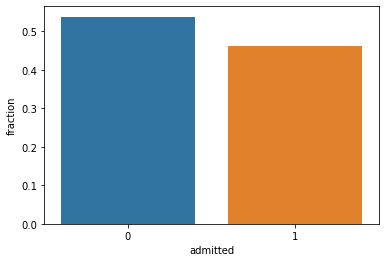

In [3]:
norm_barplot(demographics_per_id, 'admitted')

As we can see, there are more patients that were never admitted to the ICU than those who were (about 54% vs 46%).

### *age_above65*

,counts,normalized_counts
age_above65,,
0,192,0.543909
1,161,0.456091


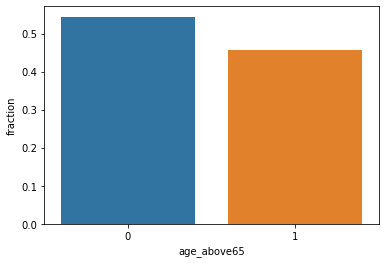

In [4]:
norm_barplot(demographics_per_id, 'age_above65')

The distribution of patients above/below 65 is similar, with about 54% in the younger group. Let's see how those variables correlate.

The correlation coefficient between
"age_above65" and "admitted"
is 0.2927185281069586.


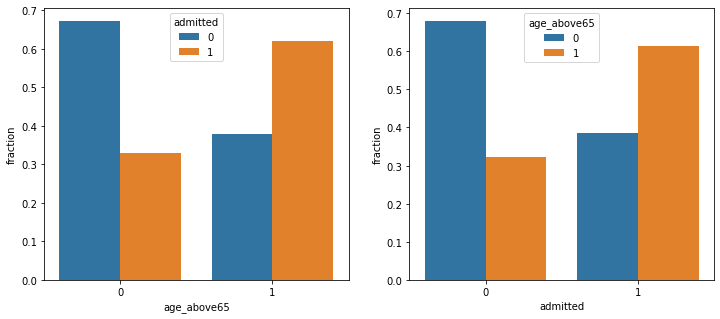

In [5]:
check_correlation(demographics_per_id, 'age_above65', 'admitted')

We can clearly see they are reasonably correlated, having a correlation coefficient of 0.29, with older people much more likely to be admitted (over 60%, against 30% for the younger group). This result is in line with the news headlines that older people are more vulnerable to the virus. This feature will definetly be part of any predictive model.

### *age_percentil*

,counts,normalized_counts
age_percentil,,
1,186,0.131915
0,179,0.126950
3,166,0.117730
2,160,0.113475
4,145,0.102837
5,128,0.090780
7,128,0.090780
6,127,0.090071
9,99,0.070213


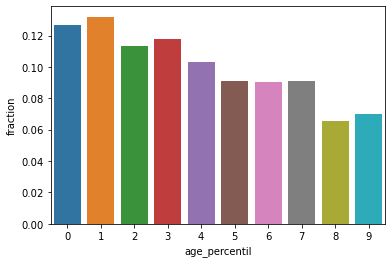

In [6]:
norm_barplot(data, 'age_percentil')

The *age_percentil* is not as uniformly distributed as one would have foreseen. Being divided into 10 percentiles, it should be expected that approximately 10% of patients should fall in each group, but this is not exactly what we see. If these percentiles have been estimated for the whole population and not just patitents, this result may be due to the small sample size.

The correlation coefficient between
"age_percentil" and "admitted"
is 0.3534418078972881.


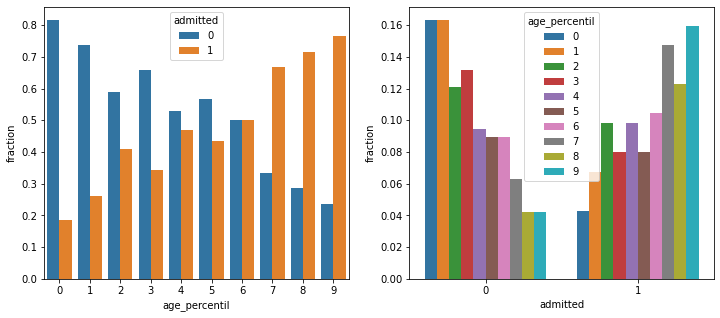

In [7]:
check_correlation(demographics_per_id, 'age_percentil', 'admitted')

As with the previous feature, we see a clear correlation with admission, being that older patients need the ICU more often.

Let's also see how both age feature correlate.

The correlation coefficient between
"age_percentil" and "age_above65"
is 0.8748601058566019.


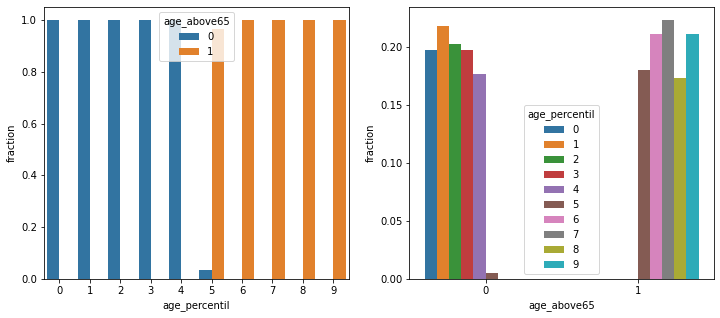

In [8]:
check_correlation(demographics_per_id, 'age_percentil', 'age_above65')

The correlation is very high, as one would think. There's apparently a single patient between the 50th and the 60th percentiles that is below 65 years old.

In [9]:
(
    demographics_per_id
    .groupby(['age_percentil', 'age_above65'], as_index=False)
    .agg(count=('age_above65', 'count'))
    .set_index(['age_percentil', 'age_above65'])
)

count
age_percentil age_above65       
0             0               38
1             0               42
2             0               39
3             0               38
4             0               34
5             0                1
              1               29
6             1               34
7             1               36
8             1               28
9             1               34

Analyzing the frequency table for both age variables we see that indeed only one patient breaks the perfect correlation.

### *gender*

,counts,normalized_counts
gender,,
0,219,0.620397
1,134,0.379603


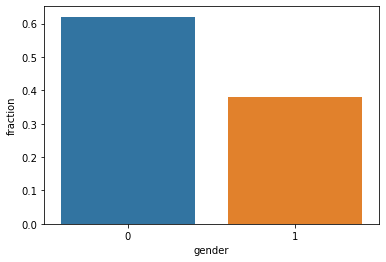

In [10]:
norm_barplot(demographics_per_id, 'gender')

The *gender* distribution is very skewed towards one side (which again we don't know which gender it corresponds to).

The correlation coefficient between
"gender" and "admitted"
is -0.11563314119566355.


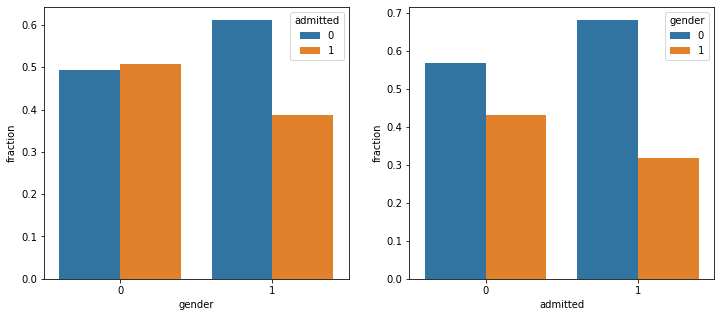

In [11]:
check_correlation(demographics_per_id, 'gender', 'admitted')

The correlation with admission is not high at 0.12, although we can see one gender tends to need the ICU somewhat more.

The correlation coefficient between
"age_percentil" and "gender"
is 0.05927120352391833.


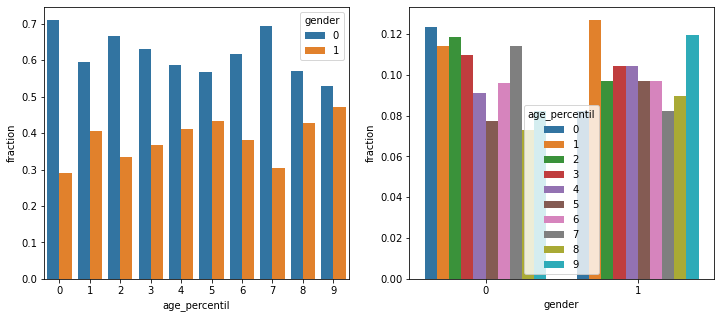

In [12]:
check_correlation(demographics_per_id, 'age_percentil', 'gender')

There also doesn't seem to be any kind of relationship between age and gender.

### Conclusion

* We can see the patient's age is reasonably well correlated with the need for ICU.
* That's true for both age variable since they are almost perfectly correlated (only one patient breaks the correlation).
    * This probably means we can keep just one of those.
* Despite being unbalanced, gender is very poorly correlated with admission.
    * Gender is also not correlated with age.

## Comorbidities

### Preparing the *DataFrame*

Again we define the *DataFrame* with one row per patient, but this time for the comorbidities.

In [13]:
comorbidities_per_id = (
    data
    .groupby('id')
    [[
        'admitted', 'disease_grouping_1', 'disease_grouping_2',
        'disease_grouping_3', 'disease_grouping_4', 'disease_grouping_5',
        'disease_grouping_6', 'htn', 'immunocompromised',
        'other'
    ]]
    .first()
)

comorbidities_per_id

,admitted,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other
id,,,,,,,,,,
0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
380,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
381,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's first check for missing values.

In [14]:
comorbidities_per_id.isna().any()

admitted              False
disease_grouping_1     True
disease_grouping_2     True
disease_grouping_3     True
disease_grouping_4     True
disease_grouping_5     True
disease_grouping_6     True
htn                    True
immunocompromised      True
other                  True
dtype: bool

We see every disease group has them.

In [15]:
comorbidities_per_id[
    comorbidities_per_id
    .isna()
    .any(axis=1)
]

,admitted,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other
id,,,,,,,,,,
199,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Selecting the rows with missing values, we find out there's actually only one patient for whom every disease data is absent. Let's drop it from this *DataFrame*.

In [16]:
comorbidities_per_id = comorbidities_per_id.dropna(how='any')

### *disease_grouping_1*

,counts,normalized_counts
disease_grouping_1,,
0.0,315,0.894886
1.0,37,0.105114


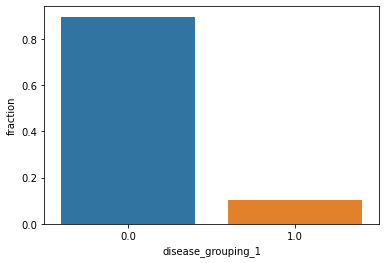

In [17]:
norm_barplot(comorbidities_per_id, 'disease_grouping_1')

The correlation coefficient between
"disease_grouping_1" and "admitted"
is 0.07182527243993275.


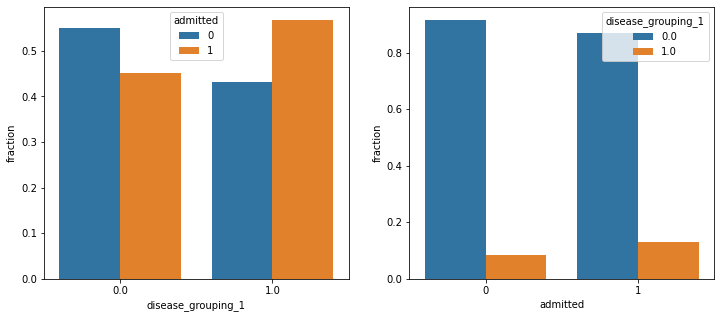

In [18]:
check_correlation(comorbidities_per_id, 'disease_grouping_1', 'admitted')

Most patients don't present any of the diseases in group 1. This group is also poorly correlated with admission.

### *disease_grouping_2*

,counts,normalized_counts
disease_grouping_2,,
0.0,344,0.977273
1.0,8,0.022727


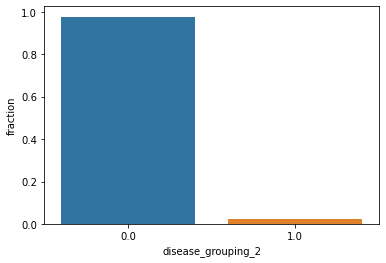

In [19]:
norm_barplot(comorbidities_per_id, 'disease_grouping_2')

The correlation coefficient between
"disease_grouping_2" and "admitted"
is 0.08775309479502298.


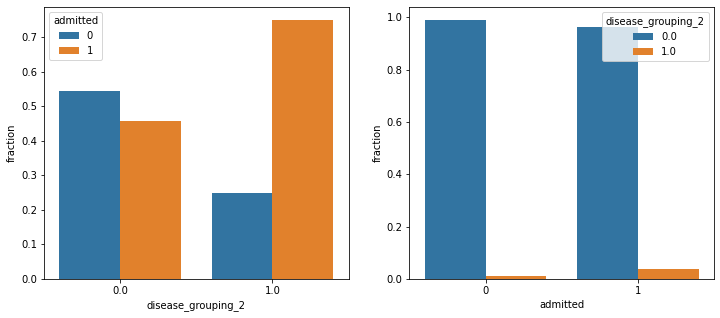

In [20]:
check_correlation(comorbidities_per_id, 'disease_grouping_2', 'admitted')

Most patients also don't present any of the diseases in group 2. Although admitted patients are more likely to have a disease in this group, its presence is not a good predictor of future ICU need.

### *disease_grouping_3*

,counts,normalized_counts
disease_grouping_3,,
0.0,320,0.909091
1.0,32,0.090909


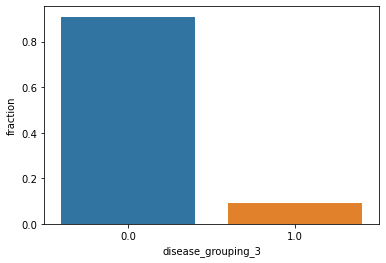

In [21]:
norm_barplot(comorbidities_per_id, 'disease_grouping_3')

The correlation coefficient between
"disease_grouping_3" and "admitted"
is 0.12251357372051519.


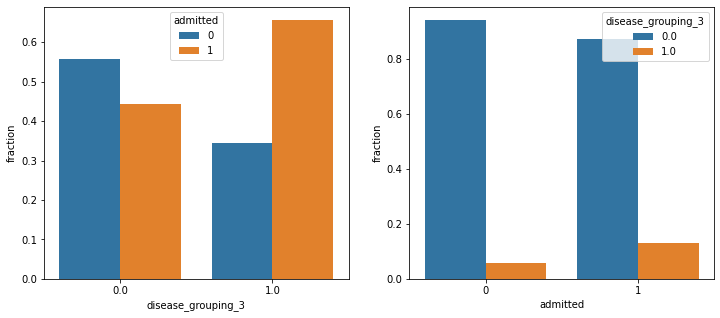

In [22]:
check_correlation(comorbidities_per_id, 'disease_grouping_3', 'admitted')

As with the previous groups, most patients don't present these diseases, which are also poorly correlated to admission.

### *disease_grouping_4*

,counts,normalized_counts
disease_grouping_4,,
0.0,345,0.980114
1.0,7,0.019886


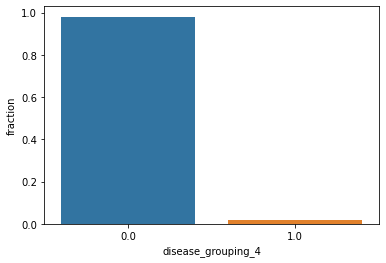

In [23]:
norm_barplot(comorbidities_per_id, 'disease_grouping_4')

The correlation coefficient between
"disease_grouping_4" and "admitted"
is 0.1125734453622877.


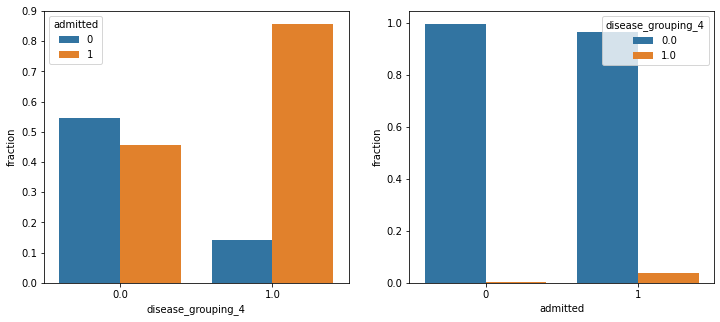

In [24]:
check_correlation(comorbidities_per_id, 'disease_grouping_4', 'admitted')

Here we reach the conclusions as with the other groups.

### *disease_grouping_5*

,counts,normalized_counts
disease_grouping_5,,
0.0,307,0.872159
1.0,45,0.127841


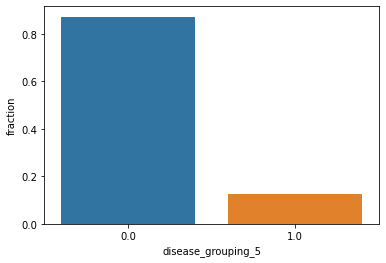

In [25]:
norm_barplot(comorbidities_per_id, 'disease_grouping_5')

The correlation coefficient between
"disease_grouping_5" and "admitted"
is 0.12220041949139765.


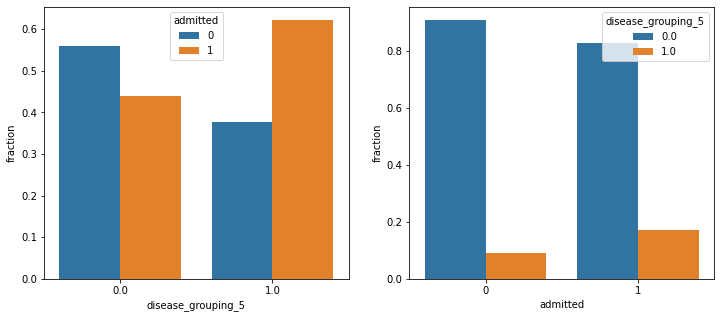

In [26]:
check_correlation(comorbidities_per_id, 'disease_grouping_5', 'admitted')

Also the same.

### *disease_grouping_6*

,counts,normalized_counts
disease_grouping_6,,
0.0,337,0.957386
1.0,15,0.042614


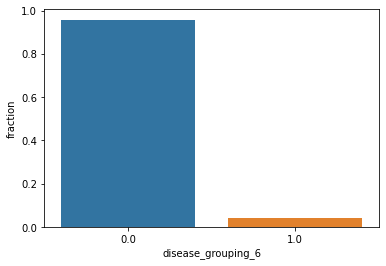

In [27]:
norm_barplot(comorbidities_per_id, 'disease_grouping_6')

The correlation coefficient between
"disease_grouping_6" and "admitted"
is -0.02668449260332346.


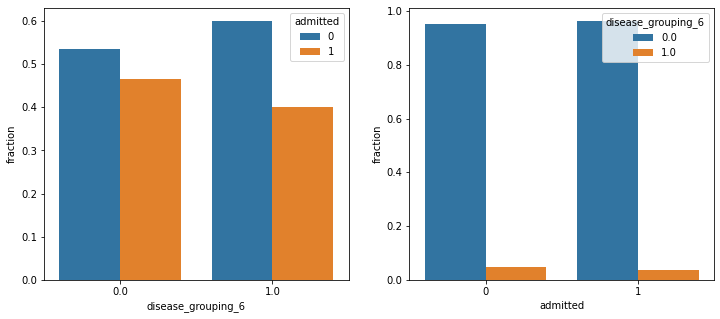

In [28]:
check_correlation(comorbidities_per_id, 'disease_grouping_6', 'admitted')

The *disease_grouping_6* is different from the previous ones in that the admitted patients are less likely to have these diseases, although the correlation with admission is just as low.

### *htn*

,counts,normalized_counts
htn,,
0.0,284,0.806818
1.0,68,0.193182


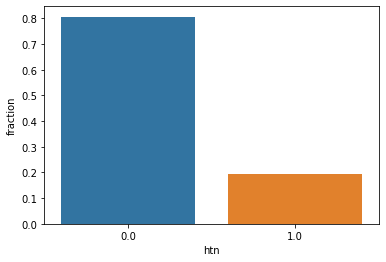

In [29]:
norm_barplot(comorbidities_per_id, 'htn')

The correlation coefficient between
"htn" and "admitted"
is 0.18055477552026855.


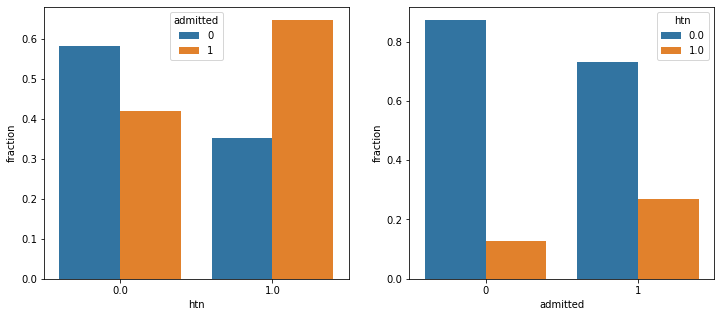

In [30]:
check_correlation(comorbidities_per_id, 'htn', 'admitted')

Up to this point, *htn* presents the greatest correlation with admission, with a correaltion coefficient of about 0.18.

### *immunocompromised*

,counts,normalized_counts
immunocompromised,,
0.0,295,0.838068
1.0,57,0.161932


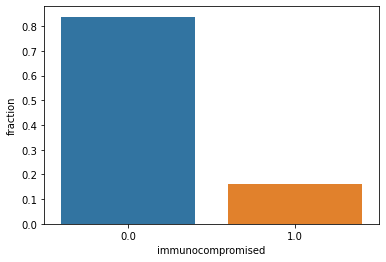

In [31]:
norm_barplot(comorbidities_per_id, 'immunocompromised')

The correlation coefficient between
"immunocompromised" and "admitted"
is 0.07122129641861913.


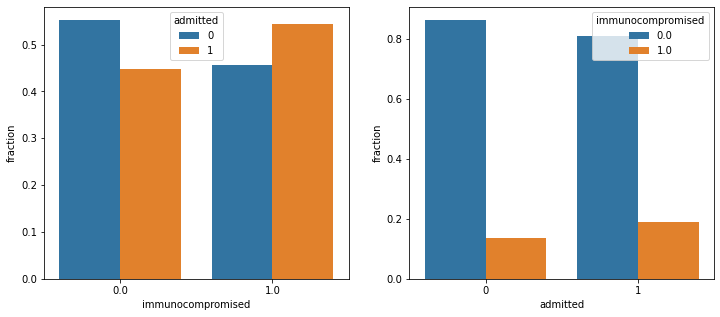

In [32]:
check_correlation(comorbidities_per_id, 'immunocompromised', 'admitted')

*immunocompromised* also has very low correlation with ICU need.

### *other*

,counts,normalized_counts
other,,
1.0,293,0.832386
0.0,59,0.167614


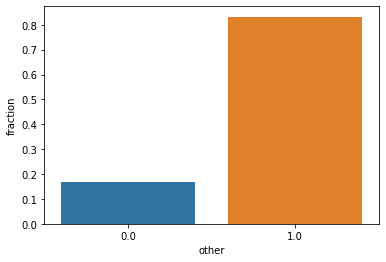

In [33]:
norm_barplot(comorbidities_per_id, 'other')

The correlation coefficient between
"other" and "admitted"
is 0.05065589475522872.


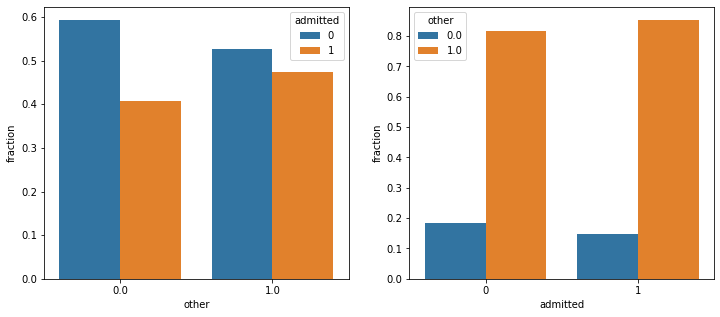

In [34]:
check_correlation(comorbidities_per_id, 'other', 'admitted')

Other diseases present a very different distribution, being much more common among patients. Nervertheless, this feature still has poor correlation with ICU admission.

After looking at all these data we may wonder if the patient's number of disease groups affects the propensity of admission. I guess this is expected to be the case because those patient with more diseases are generally more vulnerable, with a poorer health.

In [35]:
comorbidities_per_id = (
    comorbidities_per_id
    .add_column(
        'num_diseases',
        comorbidities_per_id.iloc[:, 1:].sum(axis=1)
    )
)

comorbidities_per_id

,admitted,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,num_diseases
id,,,,,,,,,,,
0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
380,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
381,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
382,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,counts,normalized_counts
num_diseases,,
0.0,58,0.164773
1.0,164,0.465909
2.0,61,0.173295
3.0,30,0.085227
4.0,16,0.045455
5.0,18,0.051136
6.0,3,0.008523
7.0,2,0.005682


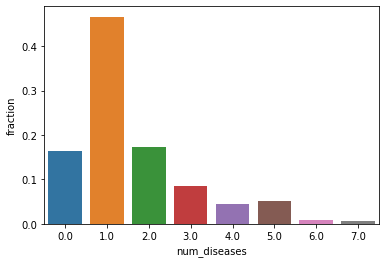

In [36]:
norm_barplot(comorbidities_per_id, 'num_diseases').sort_index()

The correlation coefficient between
"num_diseases" and "admitted"
is 0.16958390287582129.


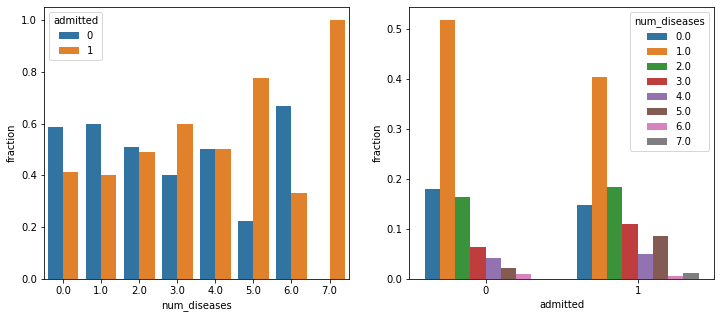

In [37]:
check_correlation(comorbidities_per_id, 'num_diseases', 'admitted')

As expected, the number of diseases has a stronger correlation with ICU need, with a coefficient of around 0.17.

We can also check if the presence of any disease group at all is informative, although I guess there shouldn't be much hope. That's because none of those diseases individually is relevant.

In [38]:
comorbidities_per_id = (
    comorbidities_per_id
    .add_column(
        'any_disease',
        comorbidities_per_id['num_diseases'].gt(0).astype('float')
    )
)

comorbidities_per_id

,admitted,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,num_diseases,any_disease
id,,,,,,,,,,,,
0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
380,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
381,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
382,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,counts,normalized_counts
any_disease,,
1.0,294,0.835227
0.0,58,0.164773


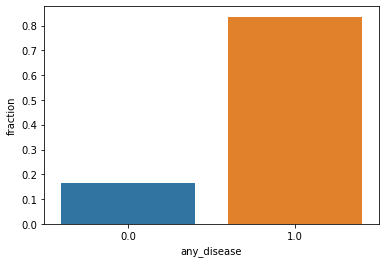

In [39]:
norm_barplot(comorbidities_per_id, 'any_disease')

The correlation coefficient between
"any_disease" and "admitted"
is 0.04389202465140091.


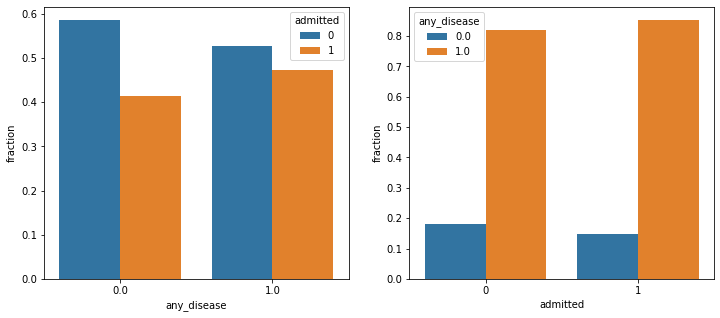

In [40]:
check_correlation(comorbidities_per_id, 'any_disease', 'admitted')

As conjectured, the correlation is basically nonexistant.

### Overall correlations

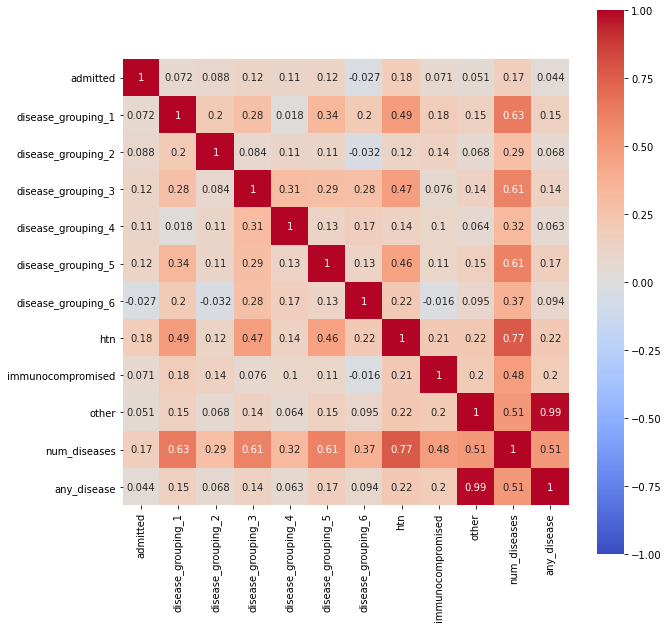

In [41]:
correlation_matrix = comorbidities_per_id.corr()

_, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    annot=True,
)

plt.show()

The heatmap confirms that none of the disease group is strongly correlated with admission. It's interesting to note that the disease groups 1, 2, 3 and htn seem to be somewhat correlated among themselves.

## Lab results and vital signs

Let's look at the lab results and vital signs Pearson correlations. Here we use the *pandas* method *corr* to generate the correlation matrix, and *numpy*'s *triu* to zero out the elements belonging to the *DataFrame*'s lower triangle. These elements will be removed later. Note that we have to reconstruct the *DataFrame* after using *triu*.

In [42]:
labs_and_vitals = data.drop(
    columns=[
       'id', 'window_of_admission', 'age_above65', 'age_percentil', 'gender',
    #    'disease_grouping_1', 'disease_grouping_2', 'disease_grouping_3',
    #    'disease_grouping_4', 'disease_grouping_5', 'disease_grouping_6',
    #    'htn', 'immunocompromised', 'other',
    ]
)

labs_and_vitals
upper_correlation_matrix = pd.DataFrame(
    np.triu(
        labs_and_vitals.corr(),
        k=1,
    ),
    index=labs_and_vitals.columns,
    columns=labs_and_vitals.columns,
)

upper_correlation_matrix

,admitted,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,...,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel
admitted,0.0,0.033205,0.085006,0.111370,0.101555,0.102890,-0.028013,0.134699,0.078029,0.044259,...,-0.323654,-0.252252,-0.305711,-0.145323,-0.296670,-0.304814,-0.331006,-0.265779,-0.306929,-0.144869
disease_grouping_1,0.0,0.000000,0.160004,0.274050,0.058865,0.268893,0.243021,0.420656,0.158887,0.152677,...,0.045840,0.033531,0.018146,-0.022063,0.000526,0.039678,0.037875,0.027600,0.018672,-0.022196
disease_grouping_2,0.0,0.000000,0.000000,0.066989,0.066377,0.063577,-0.031910,0.111193,0.135816,0.066504,...,-0.042286,-0.036082,-0.058656,-0.019445,-0.038160,-0.024872,-0.042902,-0.037172,-0.058788,-0.018283
disease_grouping_3,0.0,0.000000,0.000000,0.000000,0.279921,0.302913,0.269404,0.476215,0.075773,0.141217,...,-0.008323,0.001878,-0.001670,-0.031357,0.015570,0.016315,-0.007031,0.003293,-0.000707,-0.030990
disease_grouping_4,0.0,0.000000,0.000000,0.000000,0.000000,0.125132,0.220164,0.099949,0.060619,0.057448,...,-0.043385,-0.022398,-0.017695,-0.027468,-0.021714,-0.027651,-0.043489,-0.022448,-0.016916,-0.027578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bloodpressure_sistolic_diff_rel,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851325,0.773870,0.818708,0.467231
heart_rate_diff_rel,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750598,0.823890,0.423983
respiratory_rate_diff_rel,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.751171,0.404842
temperature_diff_rel,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412176


By melting this *DataFrame* we can get a handy list with pairwise correlations. We discard NaNs and rows which have been zeroed out, and order it in a descending fashion (disregarding the coefficient's sign). In the end, we create a list with every variable's correlation to *admitted* and another list with just the features.

In [43]:
correlation_list = (
    upper_correlation_matrix
    .reset_index()
    .rename_columns({'index': 'variable_1'})
    .melt(
        id_vars='variable_1',
        var_name='variable_2',
    )
    .dropna()
    .query('value != 0')
    .transform_column('value', np.abs)
    .sort_values(by='value', ascending=False)
)

admission_correlation_list = correlation_list.query('variable_1 == "admitted"').reset_index(drop=True)
features_correlation_list = correlation_list.query('variable_1 != "admitted"').reset_index(drop=True)

admission_correlation_list

,variable_1,variable_2,value
0,admitted,pcr_median,0.377637
1,admitted,heart_rate_diff_rel,0.331006
2,admitted,heart_rate_diff,0.323654
3,admitted,temperature_diff_rel,0.306929
4,admitted,temperature_min,0.306159
...,...,...,...
76,admitted,heart_rate_mean,0.023340
77,admitted,albumin_median,0.022477
78,admitted,ggt_median,0.022475
79,admitted,p02_arterial_median,0.021692


Taking features individually, we see that *pcr*, *heart_rate* and *temperature* are the most correlated variables to ICU admission.

In [44]:
features_correlation_list.head(50)

,variable_1,variable_2,value
0,temperature_diff,temperature_diff_rel,0.999875
1,oxygen_saturation_diff,oxygen_saturation_diff_rel,0.999773
2,respiratory_rate_diff,respiratory_rate_diff_rel,0.994434
3,bloodpressure_sistolic_diff,bloodpressure_sistolic_diff_rel,0.992595
4,bloodpressure_sistolic_mean,bloodpressure_sistolic_median,0.992511
5,heart_rate_mean,heart_rate_median,0.992095
6,bloodpressure_diastolic_diff,bloodpressure_diastolic_diff_rel,0.990397
7,temperature_mean,temperature_median,0.988362
8,bloodpressure_diastolic_mean,bloodpressure_diastolic_median,0.987134
9,heart_rate_diff,heart_rate_diff_rel,0.984950


We notice several features highly inter-correlated. Since linearly correlated (which is what the Pearson correlation coefficient characterizes) features are redudant for machine learning purposes, we can drop them out. Let's choose a threshold of 0.85.

In [45]:
features_to_drop = features_correlation_list.query('value >= 0.85')

We can drop these features from our working *DataFrame* (we choose to drop the features appearing in the column *variable_2*).

In [46]:
working_data = data.drop(columns=features_to_drop['variable_2'])

working_data

,id,admitted,window_of_admission,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,...,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff
0,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000
1,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000
2,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,-1.000000
4,2,1,4.0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-0.299145,-0.502703,-0.164179,-0.575758,0.246377,0.789474,-1.000000,-1.000000,-1.000000,-1.000000
1406,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-0.247863,-0.567568,-0.298507,-0.636364,-0.072464,0.578947,-1.000000,-1.000000,-1.000000,-1.000000
1407,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-0.247863,-0.459459,-0.343284,-0.636364,-0.072464,0.736842,-1.000000,-1.000000,-1.000000,-1.000000
1408,384,0,NaN,0,4,1,0.0,0.0,0.0,0.0,...,-0.162393,-0.567568,-0.358209,-0.696970,0.043478,0.473684,-1.000000,-1.000000,-1.000000,-1.000000


## Exploring features and treating missing values

Since our dataset presents several rows for each patient, we have to think carefully about how to treat it. First let's check if the demographics and comorbidities are constant as they should be.

In [47]:
demographics = ['age_above65', 'age_percentil', 'gender']

comorbidities = [
    'disease_grouping_1', 'disease_grouping_2', 'disease_grouping_3',
    'disease_grouping_4', 'disease_grouping_5', 'disease_grouping_6',
    'htn', 'immunocompromised', 'other',
]

num_unique_values_per_feature_per_id = (
    working_data
    .select_columns(['id']+demographics+comorbidities)
    .groupby('id')
    .nunique()
)

print('Patient ids for which each feature is not constant:\n')
for column in num_unique_values_per_feature_per_id.columns:
    print(
        column,
        # We have to consider the 0 (no value at all) because of features filled with NaNs.
        # Can't tell # nunique above to dropna because features with both NaNs and a single
        # value would have a count of 2, etc.
        num_unique_values_per_feature_per_id[~num_unique_values_per_feature_per_id[column].isin([0, 1])]
        .index
        .tolist()
    )

Patient ids for which each feature is not constant:

age_above65 []
age_percentil []
gender []
disease_grouping_1 [8, 20, 92, 172, 181, 205, 225, 313, 335, 381]
disease_grouping_2 [187]
disease_grouping_3 [122, 290, 368, 384]
disease_grouping_4 [121]
disease_grouping_5 [9, 196, 307, 330]
disease_grouping_6 [283, 295, 330, 338]
htn [4, 9, 25, 46, 58, 172, 187, 224, 294, 295, 330, 353, 368]
immunocompromised [122, 231, 236]
other [4, 5, 8, 9, 10, 11, 13, 16, 18, 20, 23, 32, 42, 45, 46, 51, 58, 60, 67, 71, 75, 79, 80, 89, 92, 93, 99, 110, 112, 114, 121, 123, 126, 131, 146, 151, 152, 153, 160, 164, 170, 172, 178, 179, 186, 192, 193, 201, 208, 210, 216, 228, 230, 231, 236, 237, 238, 241, 242, 246, 249, 258, 259, 268, 269, 271, 275, 277, 279, 283, 284, 289, 299, 317, 322, 334, 337, 338, 352, 355, 360, 368, 371, 382, 383]


On one hand, the demographics are constant for each patient. On the other hand, the comorbidities vary a lot, especially *other* diseases. It's hard to tell immediately why these features vary so much.
* It could be due to recording errors, but that seems unlikely since distinct disease groups present such different probability of this variation happening.
* Maybe the presence of each disease group could vary along time, but that also seems implausible because of the short timeframe.
* If distinct health care professionals diagnosed the presence of a given ilness at separate times, the variation we see could be explained by different people's assessment. That being the case, the best option would be to keep the most frequent value when aggregating each patient's data. Let's do this.

In [48]:
aggregated_demographics_and_comorbidities = (
    working_data
    .select_columns(['id', 'admitted', 'window_of_admission']+demographics+comorbidities)
    .groupby('id')
    .agg(lambda column: column.mode(dropna=False)[0])
)

aggregated_demographics_and_comorbidities

,admitted,window_of_admission,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other
id,,,,,,,,,,,,,,
0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1,4.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,NaN,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1,4.0,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
381,0,NaN,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,1,4.0,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the rest of the features is numerical, we can aggregate them by averaging.

In [49]:
aggregated_numerical = (
    working_data
    .drop(['admitted', 'window_of_admission']+demographics+comorbidities, axis=1)
    .groupby('id')
    .mean()
)

aggregated_numerical

,albumin_median,be_arterial_median,be_venous_median,bic_arterial_median,bic_venous_median,billirubin_median,blast_median,calcium_median,creatinin_median,ffa_median,...,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff
id,,,,,,,,,,,,,,,,,,,,,
0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,...,-0.162393,-0.459459,-0.373134,-0.636364,-0.149758,0.684211,-1.000000,-1.000000,-1.000000,-1.000000
2,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,...,-0.504274,-0.627027,0.000000,-0.636364,0.101449,1.000000,-0.626087,-0.572519,-0.852941,-1.000000
3,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,...,-0.247863,-0.506306,-0.263682,-0.454545,-0.024155,0.754386,-0.692754,-0.582697,-0.784314,-0.682540
4,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.937671,-1.0,0.357143,-0.911906,-0.771144,...,-0.076923,-0.293694,0.019900,-0.535354,0.072464,0.912281,-0.826087,-0.725191,-0.901961,-0.761905
5,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.423469,-0.887473,-0.742004,...,-0.282051,-0.553153,-0.482587,-0.535354,-0.246377,0.894737,-0.843478,-0.821883,-0.980392,-0.904762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,-0.578947,-1.0,-1.000000,-0.317073,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,...,-0.475783,-0.747748,-0.014925,-0.515152,-0.120773,0.666667,-1.000000,-1.000000,-1.000000,-1.000000
381,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.285714,-0.886766,-0.742004,...,-0.581197,-0.729730,-0.402985,-0.545455,0.130435,0.657895,-0.991304,-0.885496,-0.941176,-0.654762
382,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.960579,-1.0,0.331633,-0.915782,-0.742004,...,-0.299145,-0.605405,-0.462687,-0.454545,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000


Finally we just put the *DataFrame* back together.

In [50]:
aggregated_data = pd.concat(
    [aggregated_demographics_and_comorbidities, aggregated_numerical]
    , axis=1
)

aggregated_data

,admitted,window_of_admission,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,...,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff
id,,,,,,,,,,,,,,,,,,,,,
0,1,4.0,1,5,0,0.0,0.0,0.0,0.0,1.0,...,-0.162393,-0.459459,-0.373134,-0.636364,-0.149758,0.684211,-1.000000,-1.000000,-1.000000,-1.000000
2,1,4.0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,-0.504274,-0.627027,0.000000,-0.636364,0.101449,1.000000,-0.626087,-0.572519,-0.852941,-1.000000
3,0,NaN,0,3,1,0.0,0.0,0.0,0.0,0.0,...,-0.247863,-0.506306,-0.263682,-0.454545,-0.024155,0.754386,-0.692754,-0.582697,-0.784314,-0.682540
4,0,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,...,-0.076923,-0.293694,0.019900,-0.535354,0.072464,0.912281,-0.826087,-0.725191,-0.901961,-0.761905
5,0,NaN,0,0,0,0.0,0.0,0.0,0.0,0.0,...,-0.282051,-0.553153,-0.482587,-0.535354,-0.246377,0.894737,-0.843478,-0.821883,-0.980392,-0.904762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1,4.0,0,3,1,0.0,0.0,0.0,0.0,0.0,...,-0.475783,-0.747748,-0.014925,-0.515152,-0.120773,0.666667,-1.000000,-1.000000,-1.000000,-1.000000
381,0,NaN,1,9,0,0.0,0.0,0.0,0.0,0.0,...,-0.581197,-0.729730,-0.402985,-0.545455,0.130435,0.657895,-0.991304,-0.885496,-0.941176,-0.654762
382,1,4.0,0,4,0,0.0,0.0,0.0,0.0,0.0,...,-0.299145,-0.605405,-0.462687,-0.454545,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000


At this point we have to check for missing values.

There are 63 features with at least one missing value.


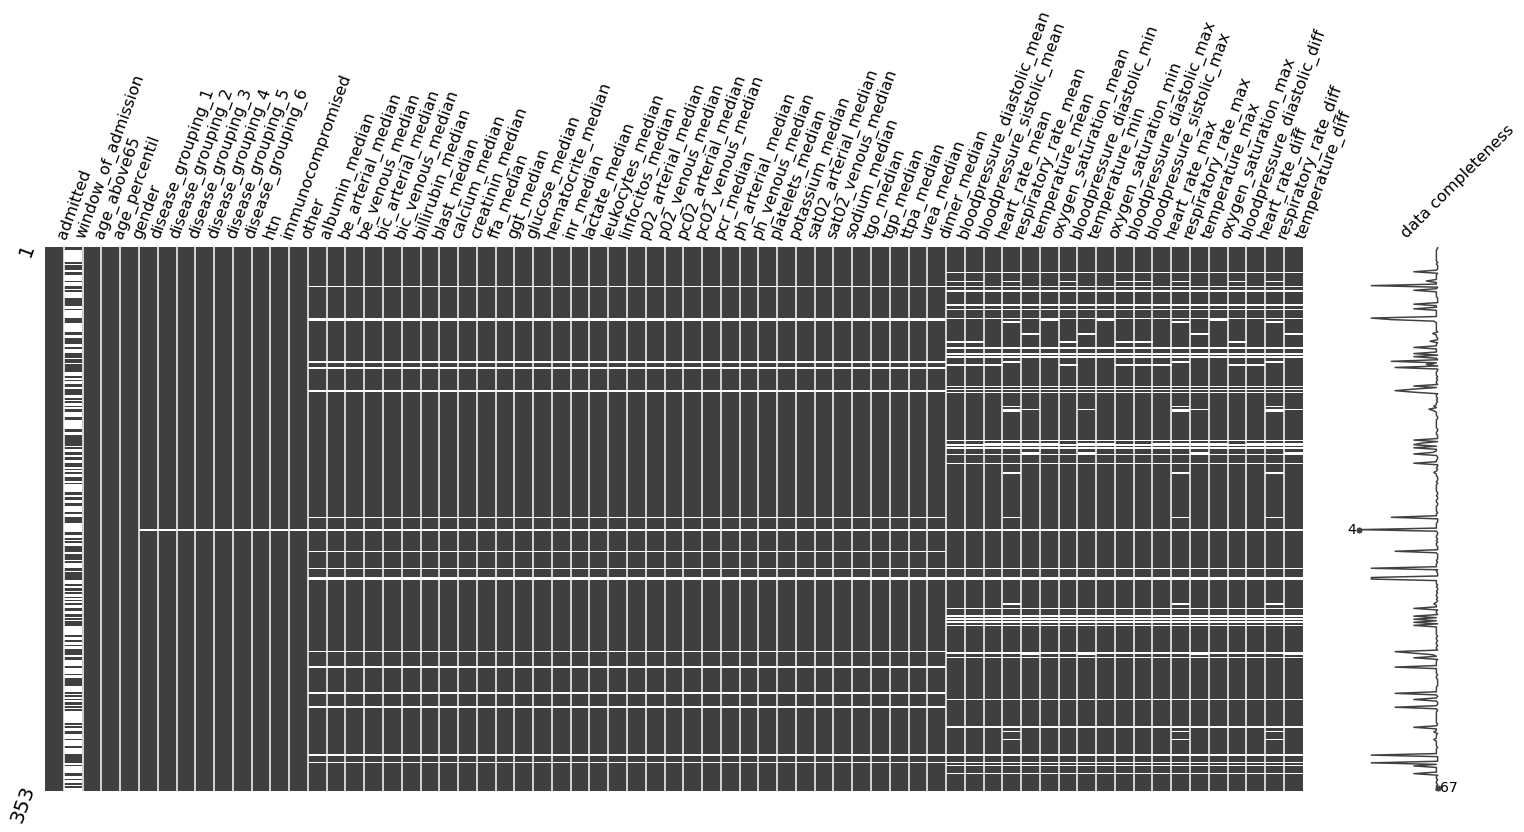

In [51]:
msno.matrix(aggregated_data, labels=True)
ax = plt.gca()
ax.tick_params(labelrotation=70)

num_cols_with_missing_value = aggregated_data.isna().any().sum()

print(
    f'There are {num_cols_with_missing_value} features with at least one missing value.'
)

Out of the 67 dataset columns, 63 have at least one missing value. Since *window_of_admission* is expected to have them because of patients who were never admitted, we can neglect it (it's also not a suitable feature for any machine learning model anyway). It's also visible that a single patient has no comorbidities information and the missing values for labs and vitals are relatively uniform, with a lot of missing for the vitals.

In [52]:
(
    aggregated_data
    .drop(columns=['window_of_admission'])
    .isna()
    .any(axis=1)
    .sum()
)

59

59 out of 353 (~17%) patients have at least one missing value. There are a few approaches we could try to deal with them:

* Dropping every missing value.
    * Considering the amount of missing values is relatively large, it would not be appropriate to just drop them. Given the small sample size we have, making it even smaller could impair any kind of modeling too much.
    * Also, we can't ignore the possibility some groups of patients could have a greater tendency to present missing values. This means that just ignoring them could introduce bias into our model.

* Replacing them with the corresponding feature's mean (or median, or mode).
    * This method has the advantage of preserving the feature's mean (or median, or mode), but every other characteristic the underlying distribution has will be affect.
    * Just as with the previous approach, we could bias our model.

* Inpute values from other patients with similar characteristics.
    * We could assume patients that are overall similar should also be similar with respect to the missing feature. That means we could use the nearest neighbours' values to fill in.
    * This procedure has the advantage of preserving the underlying distribution, at least in principle.


Let's give a shot to this last approach by using a kNN model.

In [53]:
# Since we only want to impute the features, we split the DataFrame in two.
# Also sklearn transforms return numpy arrays instead of pandas DataFrames,
# so we have to do some extra work.
cols_to_keep_array = (
    aggregated_data
    .reset_index()
    .select_columns(['id', 'admitted', 'window_of_admission'])
    .to_numpy()
)

cols_to_impute_array = (
    aggregated_data
    .reset_index()
    .drop(['id', 'admitted', 'window_of_admission'], axis=1)
    .to_numpy()
)

# The data has to be scaled for kNN to work properly.
scaler = MinMaxScaler()
scaler.fit(cols_to_impute_array)
knn_imputer = KNNImputer(n_neighbors=2)

scaled_array = scaler.transform(cols_to_impute_array)
imputed_cols_array = knn_imputer.fit_transform(scaled_array)
rescaled_imputed_cols_array = scaler.inverse_transform(imputed_cols_array)

full_array = np.hstack([cols_to_keep_array, rescaled_imputed_cols_array])

imputed_data = (
    pd.DataFrame(
        full_array,
        columns=aggregated_data.reset_index().columns
    )
    .convert_dtypes()
)

imputed_data

,id,admitted,window_of_admission,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,...,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff
0,0,1,4,1,5.0,0,0,0,0,0,...,-0.162393,-0.459459,-0.373134,-0.636364,-0.149758,0.684211,-1.0,-1.0,-1.0,-1.0
1,2,1,4,0,0.0,0,0,0,0,0,...,-0.504274,-0.627027,0.0,-0.636364,0.101449,1.0,-0.626087,-0.572519,-0.852941,-1.0
2,3,0,<NA>,0,3.0,1,0,0,0,0,...,-0.247863,-0.506306,-0.263682,-0.454545,-0.024155,0.754386,-0.692754,-0.582697,-0.784314,-0.68254
3,4,0,<NA>,0,0.0,0,0,0,0,0,...,-0.076923,-0.293694,0.0199,-0.535354,0.072464,0.912281,-0.826087,-0.725191,-0.901961,-0.761905
4,5,0,<NA>,0,0.0,0,0,0,0,0,...,-0.282051,-0.553153,-0.482587,-0.535354,-0.246377,0.894737,-0.843478,-0.821883,-0.980392,-0.904762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,380,1,4,0,3.0,1,0,0,0,0,...,-0.475783,-0.747748,-0.014925,-0.515152,-0.120773,0.666667,-1.0,-1.0,-1.0,-1.0
349,381,0,<NA>,1,9.0,0,0,0,0,0,...,-0.581197,-0.72973,-0.402985,-0.545455,0.130435,0.657895,-0.991304,-0.885496,-0.941176,-0.654762
350,382,1,4,0,4.0,0,0,0,0,0,...,-0.299145,-0.605405,-0.462687,-0.454545,-0.275362,0.736842,-1.0,-1.0,-1.0,-1.0
351,383,0,<NA>,0,3.0,1,0,0,0,0,...,-0.247863,-0.535135,-0.278607,-0.555556,-0.169082,0.77193,-0.826087,-0.78626,-0.862745,-0.857143


At this point we can start trying some ML models.

In [55]:
imputed_data.to_csv(
    Path('../data/model_input/model_input.csv'),
    index=False,
)